In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from chemprop.CUSTOM.featuriser.featurise import Featuriser, MOL_TYPES
from chemprop import data, featurizers, nn
from chemprop.nn import metrics
from chemprop.models import multi
from chemprop.nn.metrics import MSE
from lightning import pytorch as pl
import pprint


# Set up custom featuriser
1. Parses through SDF files and searches for specific types of mols (R1H and R2H). SDF files will usually contain R1H, R2H and TS - But for this we only need the first two. R1H is the molecule that has the hydrogen that is being `donated`. R2H is the the other molecule that has already `abstracted`.

    So think of the Reaction Equation:

    `R1H + R2 <-> R1 + R2H`

    So we are taking R1H and R2H forms.

2. Also, during this parsing it the SDF's, it will grab the reaction name and check for the relevant targets in the target.csv file `(Although for this purpose we will use target_sin_cos.csv - this focusses on one dihedral target and !!I have filtered out the missing dihedral moleces (marked -10) just for ease!!)`

3. Additionally, there is a function in the featurise.py that gets extra features (features that are not created by DMPNN). These features are our own.

slot 0: d_hydrogen, slot 1: a_hydrogen, slot 2: donator, slot 3: acceptor.

It is one hot encoding, where an atom is marked d_hydrogen == 1 if its the atom that is the donating hydrogen. a_hydrogen is for the abstracted hydrogen. donator is to mark which heavy atom (so not a Hydrogen) that gave away the hydrogen. and acceptor is for the heavy atom that accepted the hydrogen. So `donator` and `d_hydrogen` will have `1` in `R1H` in one of the nodes. And `acceptor` and `a_hydrogen` will have `1`in `R2H` in one of the nodes.

In [3]:
feat_data = Featuriser(
    sdf_path="../DATA/sdf_data", 
    path = "../DATA/target_data/target_data_sin_cos.csv", # If you want to use full dataset, use target_data.csv, however
    #  you will need to convert the angles for psi1 and psi2 to sin and cos
    column_targets=['psi_1_dihedral_sin','psi_1_dihedral_cos'],
    include_extra_features = False,) # <-- We will turn these off for now

Reaction rxn_191 not found in target data
Reaction rmg_rxn_16785 not found in target data
Reaction rxn_1169 not found in target data
Reaction rxn_144 not found in target data
Reaction rmg_rxn_16786 not found in target data
Reaction rxn_1257 not found in target data
Reaction rmg_rxn_1155 not found in target data
Reaction rmg_rxn_1160 not found in target data
Reaction rxn_798 not found in target data
Reaction rxn_682 not found in target data
Reaction rxn_30 not found in target data
Reaction rxn_795 not found in target data
Reaction rxn_111 not found in target data
Reaction rxn_635 not found in target data
Reaction rxn_824 not found in target data
Reaction rxn_182 not found in target data
Reaction rxn_89 not found in target data
Reaction rxn_127 not found in target data
Reaction rxn_286 not found in target data
Reaction rxn_262 not found in target data
Reaction rxn_792 not found in target data
Reaction rxn_909 not found in target data
Reaction rxn_791 not found in target data
Reaction rxn

In [4]:
print(len(feat_data))
# Reason for 2 is that it is a list in lists - list[0] is the first molecule, list[1] is the second molecule
print("Total number of pair molecules: ", len(feat_data[0]))

2
Total number of pair molecules:  1696


In [5]:
print("Molecule R1H: ", feat_data[0][0].name)
print("Molecule R2H: ", feat_data[1][0].name)


Molecule R1H:  rmg_rxn_86_r1h
Molecule R2H:  rmg_rxn_86_r2h


In [6]:
pprint.pprint(feat_data[0][0].y)
# We see that y is kept in the first molecule - not the second -> this is Chemprop's way of doing things

array([-0.7247698,  0.6889911], dtype=float32)


# Split the components

Their splitter only splits by one molecule rather than taking the two into consideration. That's fine if it's random but since my work is pair molecules, it is not ideal. So when I use their `kennard stone` it is only splitting by the first molecules - the R1H's. I have a code that takes into account both molecule but did not bother to use it here

In [7]:
component_to_split_by = 0
mols = [d.mol for d in feat_data[component_to_split_by]]

train_idx, val_idx, test_idx = data.make_split_indices(
    mols,
    "kennard_stone",
    (0.8, 0.1, 0.1),
    seed=42,
    num_replicates=1
    )

The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


In [8]:
len(train_idx), len(val_idx), len(test_idx)

# We will see that the len is 1 for each as they use `replicates` - so rather the variabls are tuples that hold different indices
# Since we set as num_replicates = 1, we will only have one set of indices in each of the tuples

(1, 1, 1)

In [9]:
len(train_idx[0])

1356

In [10]:
train_data, val_data, test_data = data.split_data_by_indices(
    feat_data, train_idx, val_idx, test_idx
)

# DMPNN Featurise & Datasets

In the `featurizers.SimpleMoleculeMolGraphFeaturizer` we can change the `atom` and `bond` featurizers from the default but we will not. Additionally, if we added the extra features as mentioned before, we need to tell it that by adjusting `extra_atom_fdim` and or `extra_bond_fdim`

Note! We will have 27 feats for Bonds even though Chemprop originally does 14. The reason for the extra 13 is that I added in the `SimpleMoleculeMolGraphFeaturizer` more information for the bonds - creating radial basis function of the bond lengths and also the angles of the bonds. However we do not need to place 13 in the `extra_bond_fdim` because I made it a core part of the featurizer.

In [11]:
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer(
    extra_atom_fdim=0, extra_bond_fdim=0
)



train_datasets = [data.MoleculeDataset(train_data[0][i], featurizer) for i in range(len(MOL_TYPES))]
val_datasets = [data.MoleculeDataset(val_data[0][i], featurizer) for i in range(len(MOL_TYPES))]
test_datasets = [data.MoleculeDataset(test_data[0][i], featurizer) for i in range(len(MOL_TYPES))]

In [12]:
len(train_datasets[0]), len(val_datasets[0]), len(test_datasets[0])

(1356, 169, 171)

In [13]:
print("Number of node feats.: ", train_datasets[0][0].mg.V.shape[1])
print("Number of edge feats.: ", train_datasets[0][0].mg.E.shape[1])

Number of node feats.:  72
Number of edge feats.:  27


In [14]:
train_mcdset = data.MulticomponentDataset(train_datasets)
val_mcdset = data.MulticomponentDataset(val_datasets)
test_mcdset = data.MulticomponentDataset(test_datasets)

In [15]:
train_loader = data.build_dataloader(train_mcdset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
val_loader = data.build_dataloader(val_mcdset, shuffle=False, batch_size=64)
test_loader = data.build_dataloader(test_mcdset, shuffle=False, batch_size=64)

# Creating the Model in parts

## MPNN

First we have the Bond Message Passer we need to set up. Here we can tell it to either create a shared encoder or separate encoder - One for R1H molecules and One for R2H molecules. They then will be aggregated together. 

![img](multi_dmpnn.png)

In [16]:
mcmp = nn.MulticomponentMessagePassing(
    blocks=[nn.BondMessagePassing(depth=6, dropout=0.2
                                  ) for _ in range(len(MOL_TYPES))],
    n_components=len(MOL_TYPES), shared = False    
)


## Aggregation
https://chemprop.readthedocs.io/en/latest/tutorial/python/models/aggregation.html

In [17]:
agg = nn.MeanAggregation()

## Optional - Loss Function
Since Chemprop does not have a loss function that handles periodic, needed to implement myself. Creating custom one explained here:
https://chemprop.readthedocs.io/en/latest/tutorial/python/loss_functions.html

In [18]:
import torch
import torch.nn.functional as F
from chemprop.nn.metrics import ChempropMetric

class CircVectorCosine(ChempropMetric):
    r"""
    Cosine‐based loss for 2-D circular vectors.
    For each (sin,cos) pair it computes
        loss = 1 - cosine_similarity(pred_vector, true_vector)
    and then applies your usual masking & weighting.
    """
    def __init__(self, task_weights=None):
        super().__init__(task_weights=task_weights)

    def _calc_unreduced_loss(self,
                             preds: torch.Tensor,    # (B, out_dim)
                             targets: torch.Tensor,  # (B, out_dim)
                             mask: torch.Tensor,     # (B, out_dim)
                             weights: torch.Tensor,  # (B,) or (B,2T) or (B,T)
                             lt_mask: torch.Tensor,
                             gt_mask: torch.Tensor
                            ) -> torch.Tensor:
        B, orig_dim = preds.shape

        # how many full (sin,cos) pairs?
        T = orig_dim // 2
        slice_width = 2 * T

        # slice everything down to exactly 2*T columns
        preds   = preds[:,   :slice_width]
        targets = targets[:, :slice_width]
        mask    = mask[:,    :slice_width]

        # now reshape safely (B, T, 2)
        preds   = preds.view(B, T, 2)
        targets = targets.view(B, T, 2)

        # vector‐level mask: require both sin & cos valid
        comp_mask = mask.view(B, T, 2).all(dim=-1)  # (B, T)

        # ==== robust weight handling ====
        w = weights
        if w.ndim == 1 and w.numel() == B:
            w = w.unsqueeze(1).expand(B, T)
        elif w.ndim == 2 and w.numel() == B * T:
            w = w.view(B, T)
        elif w.ndim == 2 and w.numel() == B * slice_width:
            w = w.view(B, T, 2).mean(dim=-1)
        else:
            w = torch.tensor(w.mean(), device=w.device).expand(B, T)
        # =================================

        # compute cosine similarity in [-1,1]
        cos_sim = F.cosine_similarity(preds, targets, dim=-1)  # (B, T)

        # loss = 1 - cosine_similarity
        loss = (1.0 - cos_sim) * comp_mask * w  # (B, T)

        return loss



## FFN Head

Again, Chemprop does not provide a periodic head so needed to create one

In [26]:
import torch
from torch import Tensor
from chemprop.nn.predictors import RegressionFFN

class PeriodicRegressionFFN(RegressionFFN):
    """
    A RegressionFFN that predicts (sin θ, cos θ) for each task and
    renormalizes to unit length.
    """
    def __init__(
        self,
        input_dim: int = 300,
        hidden_dim: int = 300,
        n_layers: int = 1,
        dropout: float = 0.0,
        activation: str = "relu",
        n_tasks: int = 1,
        criterion=None,
    ):

        super().__init__(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            n_layers=n_layers,
            dropout=dropout,
            activation=activation,
            n_tasks=n_tasks,
            criterion=criterion
        )

    def forward(self, x: Tensor) -> Tensor:
        """
        x: (batch, input_dim)
        returns: (batch, 2 * n_tasks) raw outputs,
                 which we then reshape + normalize.
        """
        raw = self.ffn(x)  # shape (batch, 2 * n_tasks)
        
        B, twoT = raw.shape
        T = twoT // 2
        
        # reshape to (batch, T, 2)
        vecs = raw.view(B, T, 2)
        
        # normalize each 2-vector to unit length
        norms = torch.norm(vecs, dim=-1, keepdim=True).clamp(min=1e-6)
        unit = vecs / norms
        
        # flatten back to (batch, 2*T)
        return unit.view(B, 2 * T)


In [38]:
num_tasks = 2
loss_fn = CircVectorCosine(task_weights=[1.0])
ffn = PeriodicRegressionFFN(
    input_dim=mcmp.output_dim,
    n_tasks=2,
    dropout=0.1,
    n_layers=2
)

## Metrics

No proper metric class for what we are measuring so need to create one

In [39]:
class CosineAngleMetric(ChempropMetric):
    """A metric reporting mean(1-cosine_similarity) across all (sample,task)."""
    def __init__(self, task_weights=None):
        super().__init__(task_weights=task_weights)

    @property
    def alias(self) -> str:
        return "mean_cosine_loss"

    def _calc_unreduced_loss(self,
        preds: torch.Tensor,
        targets: torch.Tensor,
        mask: torch.Tensor,
        weights: torch.Tensor,
        lt_mask: torch.Tensor,
        gt_mask: torch.Tensor
    ) -> torch.Tensor:
        # reuse exactly the same computation as CircVectorCosine
        return CircVectorCosine._calc_unreduced_loss(
            self, preds, targets, mask, weights, lt_mask, gt_mask
        )

In [40]:
metric_list = [CosineAngleMetric(task_weights=[1.0]), metrics.R2Score()] # Only the first metric is used for training and early stopping - can provide many though

## Bring it all together

Note Chemprop has set their optimizer and scheduler as NoamLike. So to change it you would need to change code or replace it via mcmpnn.configure_optimizer= I believe

In [41]:
mcmpnn = multi.MulticomponentMPNN(
    mcmp,
    agg,
    ffn,
    metrics=metric_list,
    warmup_epochs=8,
    max_lr = 5e-4,
    init_lr=5e-5,
    final_lr=1e-5,
    batch_norm=True

)
mcmpnn

MulticomponentMPNN(
  (message_passing): MulticomponentMessagePassing(
    (blocks): ModuleList(
      (0-1): 2 x BondMessagePassing(
        (W_i): Linear(in_features=99, out_features=300, bias=False)
        (W_h): Linear(in_features=300, out_features=300, bias=False)
        (W_o): Linear(in_features=372, out_features=300, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (tau): ReLU()
        (V_d_transform): Identity()
        (graph_transform): Identity()
      )
    )
  )
  (agg): MeanAggregation()
  (bn): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): PeriodicRegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=600, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.1, inplace=False)
        (2): Linear(in_features=300, out_features=300, bias=True)
      )
      (2): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.1, 

# Custom Callback

In [42]:
class LossHistoryCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        self.train_losses.append(trainer.callback_metrics['train_loss'].cpu().item())

    def on_validation_epoch_end(self, trainer, pl_module):
        self.val_losses.append(trainer.callback_metrics['val_loss'].cpu().item())

# 1) Instantiate callback and pass to Trainer
loss_history = LossHistoryCallback()

In [43]:
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import LearningRateMonitor

# CSVLogger writes metrics.csv under logs/lr_run/
csv_logger = CSVLogger(save_dir="logs/", name="lr_run")
lr_monitor = LearningRateMonitor(logging_interval='epoch')

trainer = pl.Trainer(
    logger=csv_logger,            # <-- use CSVLogger
    enable_checkpointing=True,
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=50,
    # profiler='simple',

    callbacks=[loss_history, lr_monitor],
)
trainer.fit(mcmpnn, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Loading `train_dataloader` to estimate number of stepping batches.

  | Name            | Type                         | Params | Mode 
-------------------------------------------------------------------------
0 | message_passing | MulticomponentMessagePassing | 463 K  | eval 
1 | agg             | MeanAggregation              | 0      | eval 
2 | bn              | BatchNorm1d                  | 1.2 K  | train
3 | predictor       | PeriodicRegressionFFN        | 271 K  | train
4 | X_d_transform   | Identity                     | 0      | train
5 | metrics         | ModuleList                   | 0      | train
-------------------------------------------------------------------------
735 K     Trainable params
0         Non-trainable params
735 K     Total params
2.942     Total estimated model params size (MB)
22        Modules in train mode
15        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [46]:
trainer.test(mcmpnn, test_loader)

/home/calvin/miniforge3/envs/habnet_env/lib/python3.12/site-packages/lightning/pytorch/core/saving.py:363: Skipping 'metrics' parameter because it is not possible to safely dump to YAML.
/home/calvin/miniforge3/envs/habnet_env/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test/mean_cosine_loss   │    0.5540871620178223     │
│          test/r2          │    -0.1568828821182251    │
└───────────────────────────┴───────────────────────────┘

[{'test/mean_cosine_loss': 0.5540871620178223, 'test/r2': -0.1568828821182251}]

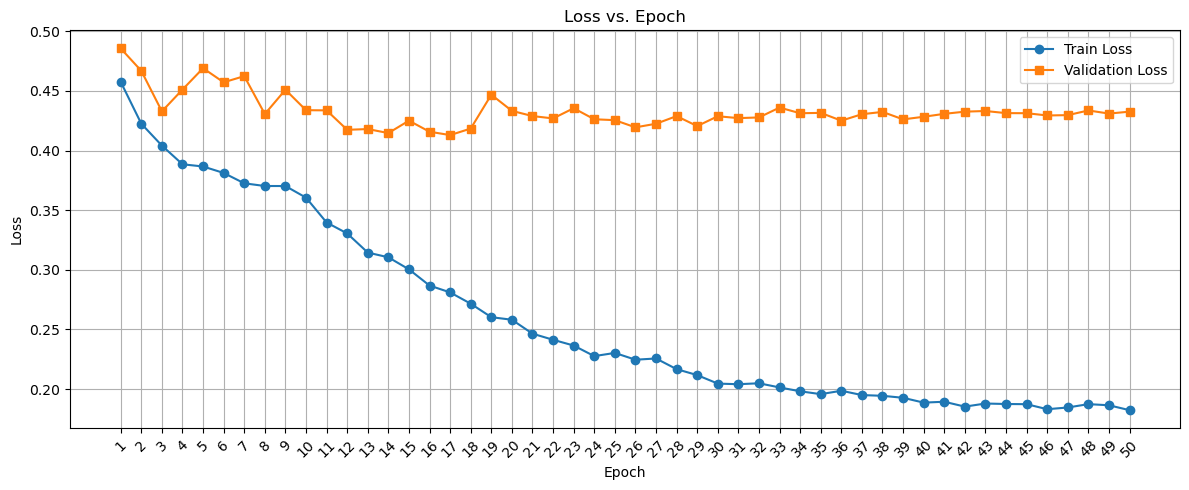

In [ ]:
import matplotlib.pyplot as plt

train_losses = loss_history.train_losses
# Need to drop the first value as it a sanity check
val_losses = loss_history.val_losses[1:]

assert len(train_losses) == len(val_losses), (
    f"Lengths now match: train={len(train_losses)}, val={len(val_losses)}"
)

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses,   label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.xticks(epochs)
# Rotate x-ticks for better visibility
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
